In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [14]:
from scipy import stats
from utils import *

In [6]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension (h/t rabernat)
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [15]:
dsets={exp:xr.open_dataset('../data/'+exp+'_glob_mean.nc.nc') for exp in ['CESM1','CESM2']}

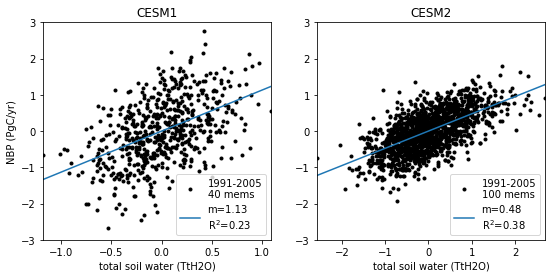

In [7]:
yy=slice('1991','2005')

plt.figure(figsize=[9,4])
for i,exp in enumerate(dsets):
    ds=dsets[exp]
    nens=len(ds.ens)
    x=detrend_dim(ds.SW.sel(year=yy),'year').values.ravel()
    y=detrend_dim(ds.NBP.sel(year=yy),'year').values.ravel()
    
    xv=np.array([x.min(),x.max()])
    lm=sm.OLS(y,sm.add_constant(x)).fit()
    m=str(np.round(lm.params[1],2))
    r2=str(np.round(lm.rsquared,2))
    plt.subplot(1,2,i+1)
    plt.plot(x,y,'k.',
             label='1991-2005\n'+str(nens)+' mems');
    plt.plot(xv,lm.params[0]+xv*lm.params[1],label='m='+m+'\n'+r'R$^2$='+r2)
    plt.ylim([-3,3])
    plt.title(exp)
    plt.xlabel('total soil water (TtH2O)')
    plt.legend(loc=4)
    plt.xlim(xv);
    
plt.subplot(121)
plt.ylabel('NBP (PgC/yr)');

In [8]:
ds=dsets['CESM2']
dvs=['GPP','AR','HR','COL_FIRE_CLOSS']
rs={exp+' (R~SW)':[np.round(np.corrcoef(
            detrend_dim(dsets[exp].SW.sel(year=yy),'year').values.ravel(),
            detrend_dim(dsets[exp][v].sel(year=yy),'year').values.ravel())[0,1],2)
    for v in dvs] for exp in dsets}
pd.DataFrame(rs,index=dvs)

,CESM1 (R~SW),CESM2 (R~SW)
GPP,0.54,0.63
AR,0.34,0.43
HR,-0.02,0.40
COL_FIRE_CLOSS,-0.67,-0.27


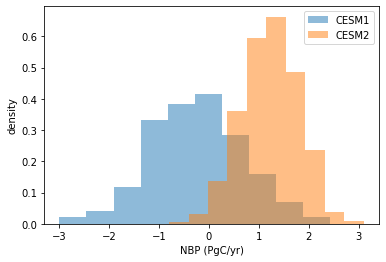

In [9]:
for exp in dsets:
    plt.hist(dsets[exp]['NBP'].sel(year=yy).values.ravel(),
             alpha=0.5,label=exp,density=True)
plt.legend()
plt.xlabel('NBP (PgC/yr)')
plt.ylabel('density');

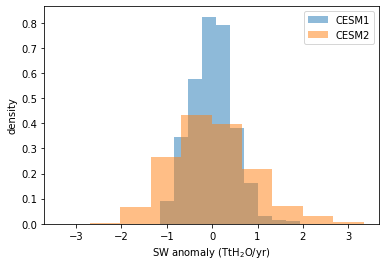

In [10]:
for exp in dsets:
    x=dsets[exp]['SW'].sel(year=yy).values.ravel()
    plt.hist(x-x.mean(),
             alpha=0.5,label=exp,density=True)
plt.legend()
plt.xlabel(r'SW anomaly (TtH$_2$O/yr)')
plt.ylabel('density');

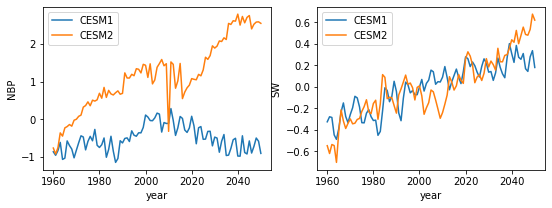

In [11]:
plt.figure(figsize=[9,3])
for i,v in enumerate(['NBP','SW']):
    plt.subplot(1,2,i+1)
    for exp in dsets:
        x=dsets[exp][v]
        if v=='SW':
            x=x-x.mean()
        plt.plot(ds.year,
                 x.mean(dim='ens'),
                 label=exp);
    plt.legend()
    plt.xlabel('year')
    plt.ylabel(v)

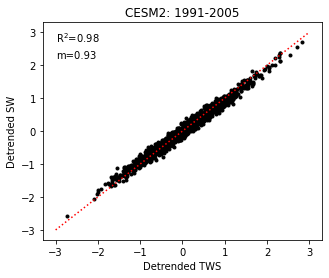

In [12]:
ds=dsets['CESM2']
tws=detrend_dim(ds.TWS.sel(year=yy),'year').values.ravel()
sw=detrend_dim(ds.SW.sel(year=yy),'year').values.ravel()
plt.figure(figsize=[5,4])
plt.plot(tws,sw,'k.');
plt.plot([-3,3],[-3,3],'r:')
plt.xlabel('Detrended TWS')
plt.ylabel('Detrended SW')

x=sm.add_constant(tws)
lm=sm.OLS(sw,x).fit()
r2=str(np.round(lm.rsquared,2))
m=str(np.round(lm.params[1],2))
plt.text(-3,2.7,r'R$^2$='+r2)
plt.text(-3,2.2,r'm='+m);
plt.title('CESM2: 1991-2005');

In [21]:
mvals={'CESM1':{},'CESM2':{}}
for exp in dsets:
    ds=dsets[exp]
    x=detrend_dim(ds.SW.sel(year=yy),'year').values
    for v in ['NBP','NPP','GPP','AR','HR','COL_FIRE_CLOSS']:
        y=detrend_dim(ds[v].sel(year=yy),'year').values
        mvals[exp][v]=[]
        for i in ds.ens.values:
            m, b, r, p, std_err = stats.linregress(x[:,i],y[:,i])
            mvals[exp][v].append(m)

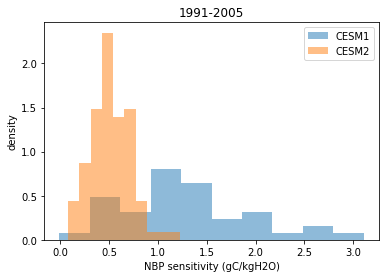

In [22]:
for exp in dsets:
    plt.hist(mvals[exp]['NBP'],density=True,alpha=0.5,label=exp)
plt.xlabel(r'NBP sensitivity (gC/kgH2O)')
plt.ylabel('density')
plt.legend()
plt.title('1991-2005');

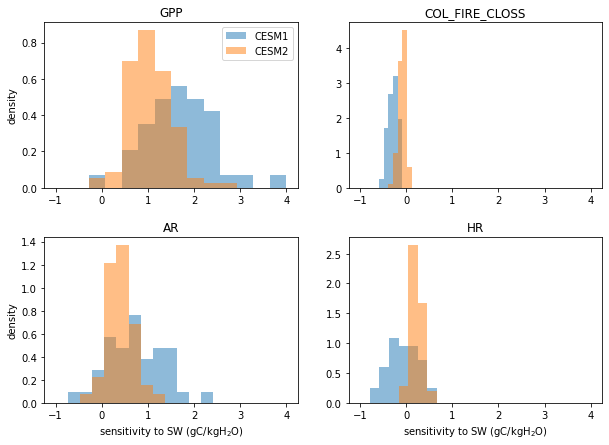

In [40]:
plt.figure(figsize=[10,7])
nbins=[15,50,20,25]
for i,v in enumerate(['GPP','COL_FIRE_CLOSS','AR','HR']):
    plt.subplot(2,2,i+1)
    for exp in dsets:
        plt.hist(mvals[exp][v],np.linspace(-1,4,nbins[i]),density=True,alpha=0.5,label=exp)
    if i==0:
        plt.legend()
    plt.title(v)
    if i>1:
        plt.xlabel(r'sensitivity to SW (gC/kgH$_2$O)')
    if i%2==0:
        plt.ylabel('density')
plt.subplots_adjust(hspace=0.3)

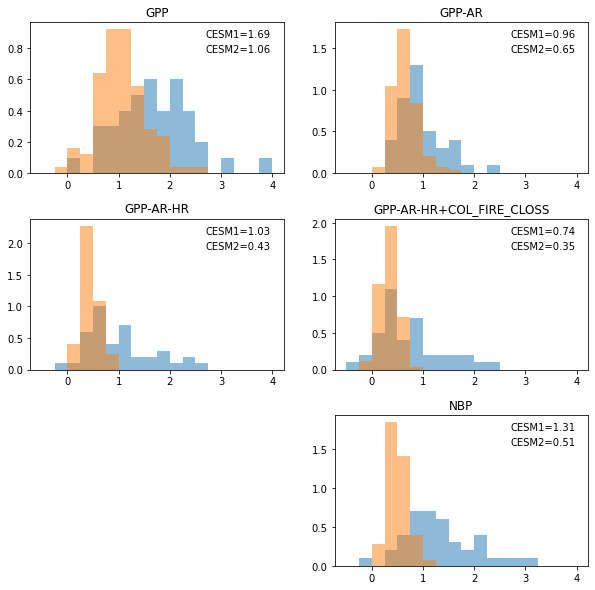

In [78]:
vlist=['GPP','AR','HR','COL_FIRE_CLOSS']
sgn=[1,-1,-1,1]
pm={1:'+',-1:'-'}
plt.figure(figsize=[10,10])
for i in range(4):
    plt.subplot(3,2,i+1)
    mavgs=[]
    for exp in dsets:
        ds=dsets[exp]
        x=detrend_dim(ds.SW.sel(year=yy),'year').values
        for j in range(i+1):
            if j==0:
                y0=ds[vlist[0]].sel(year=yy)
                s=vlist[0]
            else:
                y0=y0+sgn[j]*ds[vlist[j]].sel(year=yy)
                s=s+pm[sgn[j]]+vlist[j]
        y=detrend_dim(y0,'year').values
        ms=[]
        for k in ds.ens.values:
            m, b, r, p, std_err = stats.linregress(x[:,k],y[:,k])
            ms.append(m)
        plt.hist(ms,np.linspace(-0.5,4,19),density=True,alpha=0.5,label=exp)
        mavgs.append(str(np.round(np.mean(ms),2)))
    for ee,exp in enumerate(dsets):    
        ylims=plt.gca().get_ylim()
        plt.text(2.7,ylims[1]*(0.9-ee*0.1),exp+'='+mavgs[ee])
    plt.title(s)
plt.subplot(3,2,6)
mavgs=[]
for exp in dsets:
    mavgs.append(str(np.round(np.mean(mvals[exp]['NBP']),2)))
    plt.hist(mvals[exp]['NBP'],np.linspace(-0.5,4,19),density=True,alpha=0.5,label=exp)
for ee,exp in enumerate(dsets):    
    ylims=plt.gca().get_ylim()
    plt.text(2.7,ylims[1]*(0.9-ee*0.1),exp+'='+mavgs[ee])
plt.title('NBP')
plt.subplots_adjust(hspace=0.3)

### slope map

In [81]:
ds=xr.open_dataset('../data/slope_maps.nc')
da=(ds.pvalue<0.05)*ds.slope

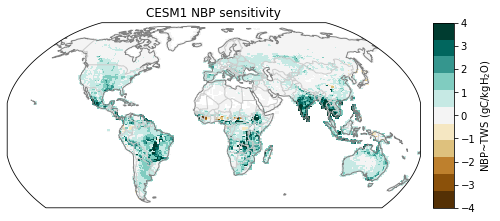

In [124]:
nicemap(da.sel(model='CESM1'),'CESM1 NBP sensitivity',r'NBP~TWS (gC/kgH$_2$O)',vmax=4)

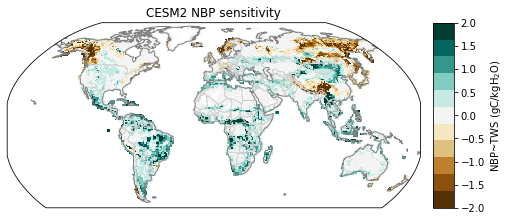

In [101]:
nicemap(da.sel(model='CESM2'),'CESM2 NBP sensitivity',r'NBP~TWS (gC/kgH$_2$O)',vmax=2)

### examine TWS anomalies

In [273]:
def get_one(v,ee,yr,cf=None):
    files=lens_files('CESM2',v,yy=(1991,2005))

    def preprocess(ds):
        return ds[[v]]

    ds=xr.open_mfdataset(files[ee],combine='nested',concat_dim='time',preprocess=preprocess)

    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    
    x=amean(ds[v].sel(time=slice('1991','2005')),cf=cf)
    
    
    return detrend_dim(x,'year').sel(year=yr)

In [274]:
dsets={exp:xr.open_dataset('../data/'+exp+'_glob_mean.nc.nc') for exp in ['CESM1','CESM2']}

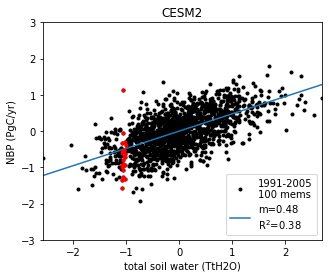

In [275]:
yy=slice('1991','2005')
exp='CESM2'
ds=dsets[exp]
nens=len(ds.ens)
x0=detrend_dim(ds.SW.sel(year=yy),'year')
x=x0.values.ravel()
y0=detrend_dim(ds.NBP.sel(year=yy),'year')
y=y0.values.ravel()

xv=np.array([x.min(),x.max()])
lm=sm.OLS(y,sm.add_constant(x)).fit()
m=str(np.round(lm.params[1],2))
r2=str(np.round(lm.rsquared,2))

plt.figure(figsize=[5,4])
plt.plot(x,y,'k.',label='1991-2005\n'+str(nens)+' mems');
plt.plot(xv,lm.params[0]+xv*lm.params[1],label='m='+m+'\n'+r'R$^2$='+r2)
plt.ylim([-3,3])
plt.title(exp)
plt.xlabel('total soil water (TtH2O)')
plt.legend(loc=4)
plt.xlim(xv);
plt.ylabel('NBP (PgC/yr)');

ix=((x0>-1.1)&(x0<-1)).values
plt.plot(x0.values[ix],y0.values[ix],'r.');

In [276]:
ees=np.tile(ds.ens,[15,1])[ix]
yys=np.tile(ds.year.sel(year=yy).values.reshape([-1,1]),[1,100])[ix]
nbps=y0.values[ix]
sws=x0.values[ix]

In [284]:
def nicemap(da,tstr,cbl,cmap=brown_green(),vmax=None,
            cticks=[],cticklabs=[],fsz=(8, 4)):
    fig = plt.figure(figsize=fsz)
    ax = fig.add_subplot(111,projection=ccrs.Robinson())
    ax.set_extent([-180, 180,-60,90], crs=ccrs.PlateCarree())
    

    mappable = da.plot(transform=ccrs.PlateCarree(),cmap=cmap,
                         add_colorbar=False,ax=ax,vmax=vmax,vmin=-vmax)

        
    ax.set_title(tstr)
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    ax.coastlines(color='grey')
    ax.add_feature(cfeature.BORDERS,edgecolor=[0.8,0.8,0.8])

    make_colorbar(ax,mappable,label=cbl,cticks=cticks,cticklabs=cticklabs)
    

In [ ]:
i=nbps.argsort()[0]
ee=ees[i]
yr=yys[i]
tws=get_one('TWS',ee,yr)
sw=str(np.round(sws[i],2))
nbp=str(np.round(nbps[i],2))
tstr=r'SW='+sw+'TtH$_2$O'
nicemap(tws,tstr,'TWS anomaly (mm)',vmax=300)
tstr='NBP='+nbp+'PgC'
y=get_one('NBP',ee,yr,24*60*60)
nicemap(y,tstr,'NBP anomaly (gC/m2/yr)',vmax=150)

In [278]:
tws

<xarray.DataArray (lat: 192, lon: 288)>
array([[ 0.00110825,  0.00110825,  0.00106836, ...,  0.00106836,
         0.00110825,  0.00110825],
       [ 0.00146228,  0.00146147,  0.00134568, ...,  0.00141444,
         0.00138601,  0.00124941],
       [-0.00488228, -0.00368704, -0.00277621, ..., -0.0046184 ,
        -0.00433966, -0.00436048],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
    year     int64 2001

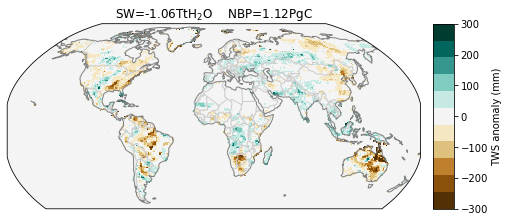

In [262]:
i=nbps.argsort()[-1]
ee=ees[i]
yr=yys[i]
tws=get_tws(ee,yr)
sw=str(np.round(sws[i],2))
nbp=str(np.round(nbps[i],2))
tstr='SW='+sw+'TtH$_2$O    NBP='+nbp+'PgC'
nicemap(tws,tstr,'TWS anomaly (mm)',vmax=300)

In [96]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
ylims

(0.0, 2.058)

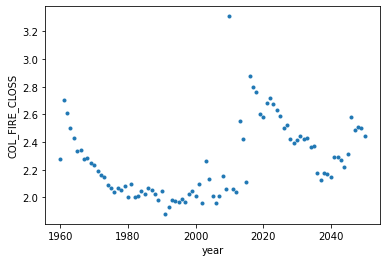

In [76]:
dsets['CESM2'].COL_FIRE_CLOSS.sel(ens=range(50,100)).mean(dim='ens').plot.line('.')

In [75]:
### lhc stuff

In [66]:
x1=detrend_dim(x,'year')
y1=detrend_dim(y,'year')
ms=[]
for i in ds.ens:
    m, b, r, p, std_err = stats.linregress(x1.sel(ens=i),y1.sel(ens=i))
    ms.append(m)

In [77]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [88]:
def gp_plot(da):
    ix=range(1,501)
    p=np.concatenate([ds[p].sel(ens=ix).values.reshape([-1,1]) for p in ds.params.values],axis=1)
    x=da.sel(ens=ix)

    ## gaussian process regression
    # Instantiate a Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1,normalize_y=True)
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(p, x);


    ypreds=[]
    for i in range(32):
        xpred = 0.5+np.zeros([20,32])
        xpred[:,i]=np.linspace(0,1,20)
        ypred, sigma = gp.predict(xpred, return_std=True)
        ypreds.append(ypred)

    da=xr.DataArray(ypreds,dims=['param','param_val'])
    da['param']=ds.params.values
    da['param_val']=np.linspace(0,1,20)
    dx=da.max(dim='param_val')-da.min(dim='param_val')

    plt.figure(figsize=[12,4])
    for i,p in enumerate(np.flip(dx.param[dx.argsort()[-10:].values])):
        plt.subplot(2,5,i+1)
        plt.plot(da.param_val,da.sel(param=p))
        plt.ylim([0.99*da.min(),1.01*da.max()])
        plt.xlim([0,1])
        plt.xticks([0,0.5,1],[])
        plt.title(p.values)

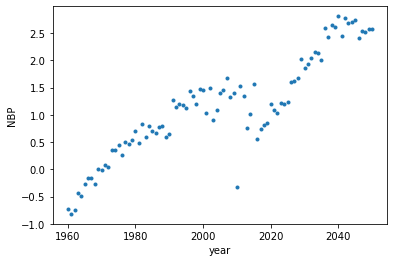

In [69]:
dsets['CESM2'].NBP.sel(ens=range(50)).mean(dim='ens').plot.line('.')

(2000.0, 2020.0)

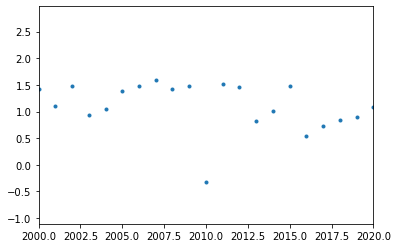

In [65]:
plt.plot(ds.year,x,'.')
plt.xlim([2000,2020])

In [63]:
dx=x[:-1]-x[1:]
ds.year[np.argmin(dx)]

<xarray.DataArray 'year' ()>
array(2010)
Coordinates:
    year     int64 2010

In [ ]:
plt.plot(x,'.')